In [1]:
cd ../

/Users/gautam/Desktop/workbench/cs330-final


In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import itertools

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import datasets
from model import Shareable

In [111]:
bs = 512
lr = 3e-4

is_two_train = datasets.IsNumber(n=2, train=True)
is_five_train = datasets.IsNumber(n=5, train=True)

is_two_val = datasets.IsNumber(n=2, train=False)
is_five_val = datasets.IsNumber(n=5, train=False)

In [112]:
is_two_train_loader = DataLoader(is_two_train, batch_size=bs, shuffle=True, drop_last=True)
is_five_train_loader = DataLoader(is_five_train, batch_size=bs, shuffle=True, drop_last=True)

is2_iter = itertools.cycle(is_two_train_loader)
is5_iter = itertools.cycle(is_five_train_loader)

In [118]:
class ConvBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
    
    def forward(self, x):
        # assume x.shape == (B, 1, 28, 28)
        return self.net(x).view(x.shape[0], -1)
        
        
class LinearBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            # nn.Linear(512, 256),
        )
    
    def forward(self, x):
        # assume x.shape == (B, 1, 28, 28)
        x = x.view(x.shape[0], -1)
        return self.net(x).view(x.shape[0], -1)
    

class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = LinearBackbone()  # ConvBackbone()
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x))
    
    
def grad_dict(loss, model):
    names, params = zip(*model.named_parameters())
    grads = torch.autograd.grad(loss, params, allow_unused=True, retain_graph=True)
    zipped_grads = list(zip(names, grads))
    return dict(zipped_grads)


def clone_grads(model):
    names, params = zip(*model.named_parameters())
    grads = [p.grad if p.grad is None else p.grad.clone() for p in params]
    return dict(zip(names, grads))


def stack_grad(grad_dict_list, task_name, param_name, flatten=True):
    grads = [g[task_name][param_name] for g in grad_dict_list]
    return torch.stack(grads).view(len(grads), -1)


def low_pass_filter(x, filter_size=25):
    x = torch.tensor(x)
    x_smooth = F.conv1d(x[None], torch.ones(1, 1, filter_size) / filter_size)
    return x_smooth.numpy()

In [123]:
steps = 1000

tasks = {
    't0': is2_iter,
    't1': is5_iter,
}
mtl = SharedMTL(tasks.keys())
opt = torch.optim.Adam(mtl.parameters(), lr=lr)

step = 0
losses = []
grads = []
while step < steps:
    task_losses = {}
    task_grads = {}
    
    opt.zero_grad()
    for task_name, task_iter in tasks.items():
        batch = next(task_iter)
        x, y = batch
        pred = mtl(x[:, None, ...], task_name)
        loss = F.binary_cross_entropy_with_logits(pred, y[..., None])
        loss.backward()
        task_grads[task_name] = clone_grads(mtl)
        task_losses[task_name] = loss.item()
    
    opt.step()

    losses.append(task_losses)
    grads.append(task_grads)
    
    if step % 10 == 0:
        print('step', step, task_losses)
    
    step += 1

step 0 {'t0': 0.6958765983581543, 't1': 0.6577562689781189}
step 10 {'t0': 0.4335991442203522, 't1': 0.4367354214191437}
step 20 {'t0': 0.37509864568710327, 't1': 0.29275017976760864}
step 30 {'t0': 0.282408744096756, 't1': 0.22327299416065216}
step 40 {'t0': 0.3418438732624054, 't1': 0.2781030833721161}
step 50 {'t0': 0.2296665757894516, 't1': 0.2444130778312683}
step 60 {'t0': 0.2068483531475067, 't1': 0.23159490525722504}
step 70 {'t0': 0.1750597357749939, 't1': 0.2042076289653778}
step 80 {'t0': 0.1613437682390213, 't1': 0.1853712648153305}
step 90 {'t0': 0.13259248435497284, 't1': 0.18245059251785278}
step 100 {'t0': 0.13619142770767212, 't1': 0.16524817049503326}
step 110 {'t0': 0.12522107362747192, 't1': 0.15570902824401855}
step 120 {'t0': 0.12259194254875183, 't1': 0.12820282578468323}
step 130 {'t0': 0.11615460366010666, 't1': 0.15011674165725708}
step 140 {'t0': 0.12781381607055664, 't1': 0.16950125992298126}
step 150 {'t0': 0.1285681426525116, 't1': 0.11274921894073486}
ste

backbone.net.0.weight 0.66774803 0.0038660155


/var/folders/yc/sg2v7pxx3lx5qvhgy7szdch40000gn/T/ipykernel_21261/3472356907.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


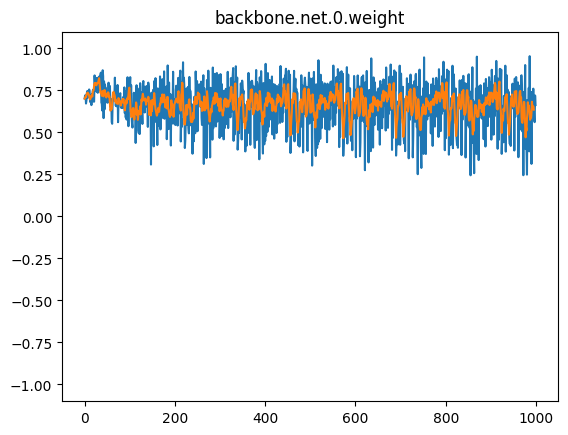

backbone.net.0.bias 0.6619463 0.013161001


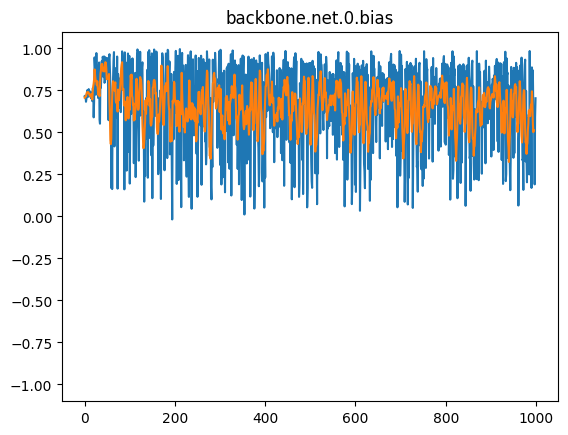

In [124]:
param_keys = ['backbone.' + k for k in list(mtl.backbone.state_dict().keys())]

for key in param_keys:
    g0 = stack_grad(grads, 't0', key)
    g1 = stack_grad(grads, 't1', key)
    
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = low_pass_filter(cosine, filter_size=5)[0]
    
    print(key, smooth_cos.mean(), smooth_cos.var())
    
    plt.title(key)
    plt.ylim([-1.1, 1.1])
    plt.plot(cosine)
    plt.plot(smooth_cos)
    plt.show()

['net.0.weight',
 'net.0.bias',
 'net.3.weight',
 'net.3.bias',
 'net.6.weight',
 'net.6.bias']